In [1]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

### Setups

In [2]:
size_list = [s for s in range(3, 11)]
with open('../../data/trueans.pkl', 'rb') as f:
    dict_true = pickle.load(f)

## Combine results

### Brute solver

In [3]:
with open('../../data/trueans.pkl', 'rb') as f:
    dict_true = pickle.load(f)

_s = []
_t = []
for size in size_list:
    _s += [size]
    _t += [sum(dict_true['time'][size])/len(dict_true['time'][size])]

pd.DataFrame({'size': _s, 'time': _t}).to_csv('./outputs/csv/Brute.csv', index=False)

### GQCO

In [4]:
se_list = [0, 373, 42]
t_list = [1.0, 2.0]
cl_list = [1, 5, 10, 20, 100]

_s = []
_se = []
_temp = []
_cl = []
_t = []
_t1 = []
_t2 = []
_t3 = []
_acc = []
for se in se_list:
    for temp in t_list:
        for cl in cl_list:
            for size in size_list:
                with open(f'./outputs/pkl/gqcoans_s{se}_t{temp}_cl{int(cl)}_s{size}.pkl', 'rb') as f:
                    dct = pickle.load(f)

                sum_t = 0
                sum_t1 = 0
                sum_t2 = 0
                for i in range(len(dct['answer'])):
                    gqcoans = dct['answer'][i]
                    trueans = dict_true['answer'][size][i]
    
                    sum_t += dct['time'][i][2] - dct['time'][i][0]
                    sum_t1 += dct['time'][i][1] - dct['time'][i][0]
                    sum_t2 += dct['time'][i][2] - dct['time'][i][1]
    
                _s += [size]
                _se += [se]
                _temp += [temp]
                _cl += [cl]
                _t += [sum_t / len(dct['answer'])]
                _t1 += [sum_t1 / len(dct['answer'])]
                _t2 += [sum_t2 / len(dct['answer'])]
                _acc += [sum(dct['answer']) / len(dct['answer'])]

pd.DataFrame({
    'size': _s, 
    'seed': _se,
    'temperature': _temp,
    'num_clone': _cl,
    'time': _t,
    'time1': _t1,
    'time2': _t2,
    'accuracy': _acc
}).to_csv('./outputs/csv/GQCO.csv', index=False)

### SA

In [5]:
r_list = [10]
sw_list = [100, 1000, 10000, 100000, 1000000, 10000000]

_s = []
_r = []
_sw = []
_t = []
_acc = []
for r in r_list:
    for sw in sw_list:
        for size in size_list:
            with open(f'./outputs/pkl/saans_r{int(r)}_sw{int(sw)}_s{size}.pkl', 'rb') as f:
                dct = pickle.load(f)

            is_correct = 0
            sum_t = 0
            for i in range(len(dct['answer'])):
                saans = dct['answer'][i]
                trueans = dict_true['answer'][size][i]

                if len(set(saans) & set(trueans)):
                    is_correct += 1

                sum_t += dct['time'][i]

            _s += [size]
            _r += [r]
            _sw += [sw]
            _t += [sum_t / len(dct['answer'])]
            _acc += [is_correct / len(dct['answer'])]

pd.DataFrame({
    'size': _s, 
    'num_reads': _r,
    'num_sweeps': _sw,
    'time': _t,
    'accuracy': _acc
}).to_csv('./outputs/csv/SA.csv', index=False)

### QAOA

In [6]:
l_list = [1, 2, 3, 4]

_s = []
_l = []
_t = []
_acc = []
for l in l_list:
    for size in size_list:
        with open(f'./outputs/pkl/qaoaans_l{int(l)}_s{size}.pkl', 'rb') as f:
            dct = pickle.load(f)

        is_correct = 0
        sum_t = 0
        for i in range(len(dct['answer'])):
            qaoaans = dct['answer'][i]
            trueans = dict_true['answer'][size][i]

            if len(set(qaoaans) & set(trueans)):
                is_correct += 1

            sum_t += dct['time'][i]

        _s += [size]
        _l += [l]
        _t += [sum_t / len(dct['answer'])]
        _acc += [is_correct / len(dct['answer'])]

pd.DataFrame({
    'size': _s, 
    'num_repeats': _l,
    'time': _t,
    'accuracy': _acc
}).to_csv('./outputs/csv/QAOA.csv', index=False)

In [7]:
result_brute = pd.read_csv('./outputs/csv/Brute.csv')
result_gqco = pd.read_csv('./outputs/csv/GQCO.csv')
result_sa = pd.read_csv('./outputs/csv/SA.csv')
result_qaoa = pd.read_csv('./outputs/csv/QAOA.csv')

result_gqco = result_gqco[(result_gqco['seed']==42)&((result_gqco['temperature']==2.0))]

## Plot

In [8]:
## GQCO
tmp_result_gqco = result_gqco[(result_gqco['temperature']==2.0) & (result_gqco['num_clone']==100)]
tmp_result_gqco = tmp_result_gqco[['size', 'accuracy']]
tmp_result_gqco['solver'] = 'GQCO' 

## SA
tmp_result_sa = result_sa[(result_sa['num_sweeps']==10000000)]
tmp_result_sa = tmp_result_sa[['size', 'accuracy']]
tmp_result_sa['solver'] = 'SA' 

## QAOA
tmp_result_qaoa = result_qaoa[(result_qaoa['num_repeats']==4)]
tmp_result_qaoa = tmp_result_qaoa[['size', 'accuracy']]
tmp_result_qaoa['solver'] = 'QAOA' 

df_forplot = pd.concat([tmp_result_gqco, tmp_result_sa, tmp_result_qaoa])

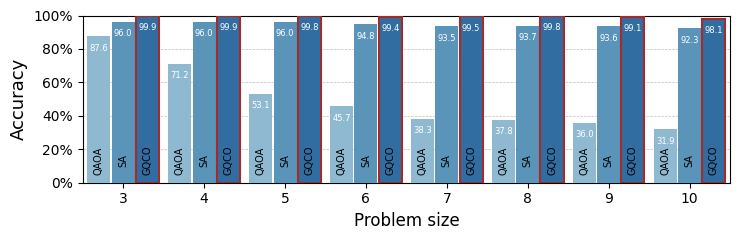

In [9]:
palette = {
    'Brute-force': sns.color_palette('Blues', 24)[10],
    'SA': sns.color_palette('Blues', 24)[14],
    'QAOA': sns.color_palette('Blues', 24)[10],
    # 'GQCO': sns.color_palette("viridis", 24)[3],
    'GQCO': sns.color_palette('Blues', 24)[18],
    'Random': sns.color_palette("Blues", 24)[1],
}


plt.figure(figsize=(7.5, 2.5))
ax = sns.barplot(
    data=df_forplot, 
    hue='solver',
    y='accuracy',
    x='size',
    hue_order=['QAOA', 'SA', 'GQCO'],
    palette=palette,
    zorder=10,
    width=0.9,
    gap=0.05
)
plt.grid(axis='y', which='both', color='gray', alpha=0.5, linestyle='--', linewidth=0.5, zorder=2)
plt.xlabel('Problem size', size=12)
plt.ylabel('Accuracy', size=13)
plt.ylim([0, 1])
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
for p, solver in zip(ax.patches, ['QAOA']*8+['SA']*8+['GQCO']*8):
    if solver == 'GQCO':
        p.set_edgecolor('brown')  # Set border color
        p.set_linewidth(1.5)  # Set border thickness
    
    if p.get_height() > 0:
        ax.annotate(
            f'{p.get_height() * 100:.1f}', 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', 
            va='center', 
            fontsize=6, 
            color='white', 
            xytext=(0, -8.5), 
            textcoords='offset points',
            zorder=11,
            rotation=0
        )
        ax.annotate(
            solver, 
            (p.get_x() + p.get_width() / 2., 0.05), 
            ha='center', 
            va='center', 
            fontsize=7, 
            color='black', 
            xytext=(0, 10), 
            textcoords='offset points',
            zorder=11,
            rotation=90
        )
ax.legend_.remove()
plt.tight_layout()
plt.savefig('./outputs/svg/200_acc.svg')

In [10]:
def pick_minimum_time(df, th, solver=''):
    size_list = df['size'].unique()
    _s = []
    _t = []
    _n = []
    for size in size_list:
        tmp_df = df[(df['size']==size)&(df['accuracy']>=th)]
        if len(tmp_df) > 0:
            _time = tmp_df['time'].min()
        else:
            _time = None
            # tmp_df2 = df[df['size']==size]
            # _time = tmp_df2.loc[tmp_df2['accuracy'].idxmax(), 'time']
        _s += [size]
        _t += [_time]
        _n += [solver]

    return pd.DataFrame({'size': _s, 'time': _t, 'solver': _n})
            

In [11]:
th = 0.9
tmp_result_gqco = pick_minimum_time(result_gqco, th, solver='GQCO')
tmp_result_sa = pick_minimum_time(result_sa, th, solver='SA')
tmp_result_qaoa = pick_minimum_time(result_qaoa, th, solver='QAOA')

tmp_result_brute = result_brute[['size', 'time']]
tmp_result_brute['solver'] = 'Brute-force'

df_forplot = pd.concat([tmp_result_gqco, tmp_result_sa, tmp_result_qaoa, tmp_result_brute]).reset_index()

/tmp/ipykernel_128991/3732020921.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_forplot = pd.concat([tmp_result_gqco, tmp_result_sa, tmp_result_qaoa, tmp_result_brute]).reset_index()


In [12]:
# tmp_result_gqco = result_gqco[result_gqco['num_clone']==100][['size', 'time']]
# tmp_result_gqco['solver'] = 'GQCO'

# tmp_result_sa = result_gqco[result_sa['num_clone']==100][['size', 'time']]
# tmp_result_sa['solver'] = 'SA'
# tmp_result_qaoa = pick_minimum_time(result_qaoa, th, solver='QAOA')

# tmp_result_brute = result_brute[['size', 'time']]
# tmp_result_brute['solver'] = 'Brute-force'

# df_forplot = pd.concat([tmp_result_gqco, tmp_result_sa, tmp_result_qaoa, tmp_result_brute]).reset_index()

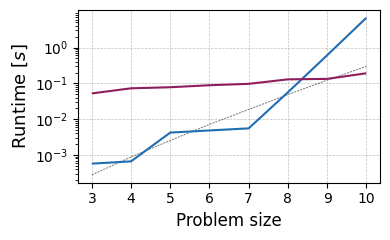

In [20]:
# palette = {
#     'Brute-force': 'black',#sns.color_palette('Blues', 24)[20],
#     'SA': sns.color_palette('Blues', 24)[18],
#     'QAOA': sns.color_palette('crest', 24)[10],
#     'GQCO': sns.color_palette("rocket", 24)[8],
#     'Random': sns.color_palette("Blues", 24)[5],
# }
palette = {
    'Brute-force': (0, 0, 0, 0.5),  # Black with alpha of 0.7
    'SA': (*sns.color_palette('Blues', 24)[18], 1),  # Original color with alpha of 0.7
    'QAOA': (*sns.color_palette('crest', 24)[10], 1),
    'GQCO': (*sns.color_palette("rocket", 24)[8], 1),
    'Random': (*sns.color_palette("Blues", 24)[5], 1),
}
# line_styles = {'Brute-force': '--', 'QAOA': '-', 'SA': '-', 'GQCO': '-'}
line_styles = {'Brute-force': (2,1), 'QAOA': (2,1), 'SA': (1,0), 'GQCO': (1,0)}

plt.figure(figsize=(4, 2.5))
# sns.lineplot(data=df_forplot, hue='solver', y='time', x='size', hue_order=['Brute-force', 'QAOA', 'SA', 'GQCO'], palette=palette, zorder=10, linewidth=1.5, style='solver', dashes=line_styles)
# Define linewidths for each solver
linewidths = {
    'Brute-force': 0.75,
    'QAOA': 1.0,
    'SA': 1.5,
    'GQCO': 1.5,
    'Random': 1.0,
}

# Plot with specified linewidth for each line
for solver in ['Brute-force', 'QAOA', 'SA', 'GQCO', 'Random']:
    sns.lineplot(data=df_forplot[df_forplot['solver'] == solver], y='time', x='size', 
                 color=palette[solver], linewidth=linewidths[solver], label=solver, 
                 dashes=line_styles.get(solver, ()))  # Add specific dashes if needed

# plt.legend(title='Solver', loc='lower center', bbox_to_anchor=(1.09, 0.5), ncol=1)#, labels=['Random', 'QAOA', 'SA', 'GQE'])

# Removing legend since we are adding text labels
plt.legend([], [], frameon=False)

# # Adding text labels at the end of each line
# for solver in ['Brute-force', 'QAOA', 'SA', 'GQCO']:
#     # Get the last x and y values for the specific solver line
#     x_pos = df_forplot[df_forplot['solver'] == solver]['size'].max()
#     y_pos = df_forplot[(df_forplot['solver'] == solver) & (df_forplot['size'] == x_pos)]['time'].values[0]
#     plt.text(x_pos + 0.5, y_pos, solver, color=palette[solver], fontsize=10, verticalalignment='center')



plt.yscale('log')
plt.xlabel('Problem size', size=12)
plt.ylabel(f'Runtime [$s$]', size=13)
plt.yticks(ticks=[10**(-3), 10**(-2), 10**(-1), 10**(0)])
plt.xticks(ticks=[3,4,5,6,7,8,9,10])
plt.grid(color='gray', alpha=0.5, linestyle='--', linewidth=0.5, zorder=2)
plt.tight_layout()
plt.savefig('./outputs/svg/201_time.svg')

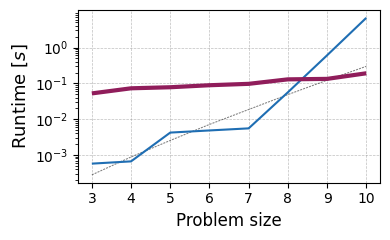

In [19]:
linewidths = {
    'Brute-force': 0.75,
    'QAOA': 1.0,
    'SA': 1.5,
    'GQCO': 3,
    'Random': 1.0,
}

plt.figure(figsize=(4, 2.5))
# Plot with specified linewidth for each line
for solver in ['Brute-force', 'QAOA', 'SA', 'GQCO', 'Random']:
    sns.lineplot(data=df_forplot[df_forplot['solver'] == solver], y='time', x='size', 
                 color=palette[solver], linewidth=linewidths[solver], label=solver, 
                 dashes=line_styles.get(solver, ()))  # Add specific dashes if needed

# Removing legend since we are adding text labels
plt.legend([], [], frameon=False)

plt.yscale('log')
plt.xlabel('Problem size', size=12)
plt.ylabel(f'Runtime [$s$]', size=13)
plt.yticks(ticks=[10**(-3), 10**(-2), 10**(-1), 10**(0)])
plt.xticks(ticks=[3,4,5,6,7,8,9,10])
plt.grid(color='gray', alpha=0.5, linestyle='--', linewidth=0.5, zorder=2)
plt.tight_layout()
plt.savefig('./outputs/svg/201_time_bold.svg')

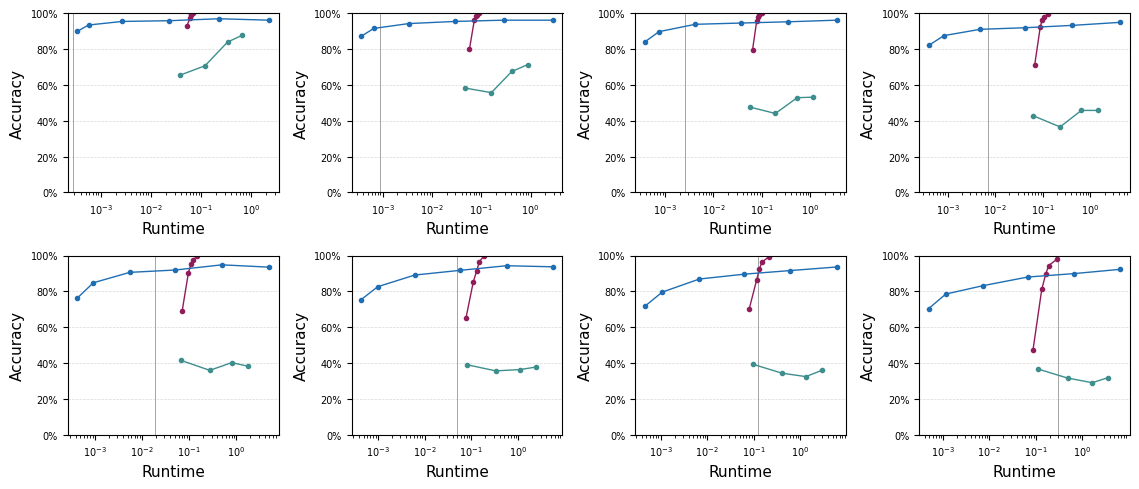

In [14]:
palette = {
    'Brute-force': 'black',#sns.color_palette('Blues', 24)[20],
    'SA': sns.color_palette('Blues', 24)[18],
    'QAOA': sns.color_palette('crest', 24)[10],
    'GQCO': sns.color_palette("rocket", 24)[8],
    'Random': sns.color_palette("Blues", 24)[5],
}

fig = plt.figure(figsize=(11.5, 5))

for loc, size in zip([1,2,3,4,5,6,7,8], [3,4,5,6,7,8,9,10]):
    # size_gqco = result_gqco[result_gqco['size']==size]
    size_gqco = result_gqco[(result_gqco['size']==size)&(result_gqco['temperature']==2.0)]
    size_qaoa = result_qaoa[result_qaoa['size']==size]
    size_sa = result_sa[result_sa['size']==size]
    size_brute = result_brute[result_brute['size']==size]
    
    ax = fig.add_subplot(2, 4, loc)
    
    plt.plot(size_gqco['time'], size_gqco['accuracy'], linewidth=1, marker='o', markersize=3, color=palette['GQCO'])
    plt.plot(size_qaoa['time'], size_qaoa['accuracy'], linewidth=1, marker='o', markersize=3, color=palette['QAOA'])
    plt.plot(size_sa['time'],   size_sa['accuracy'], linewidth=1, marker='o', markersize=3, color=palette['SA'])
    plt.grid(axis='y', which='both', color='gray', alpha=0.3, linestyle='--', linewidth=0.5, zorder=2)
    plt.xlabel('Runtime', size=11)
    plt.ylabel('Accuracy', size=11)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))
    ax.set_xscale('log')
    ax.set_xticks(ticks=[10**(-3), 10**(-2), 10**(-1), 10**(0)])
    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=7)
    ax.axvline(x=size_brute['time'].iloc[0], color='gray', linestyle='-', linewidth=0.5, zorder=1)
    ax.set_ylim([0, 1])
    # ax.set_title(f'Size: {size}', size=11)
plt.tight_layout()
plt.savefig('./outputs/svg/202_time-vs-acc_.svg')